In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc

from shared.utils import *
from shared.kaggle_path import *

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
filepath = []
label = []

i = 0
for classes in os.listdir(TRAIN_IMAGE_PATH):
    for file in os.listdir(os.path.join(TRAIN_IMAGE_PATH, classes)):
        path = os.path.join(TRAIN_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

train_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(train_df.shape)
print(train_df['label'].unique())
train_df.head()

(33348, 2)
['angry' 'happy' 'sad' 'disgust' 'fear' 'surprise' 'neutral']


,filepath,label
0,/kaggle/working/dataset/new_data/train/angry/T...,angry
1,/kaggle/working/dataset/new_data/train/angry/T...,angry
2,/kaggle/working/dataset/new_data/train/angry/T...,angry
3,/kaggle/working/dataset/new_data/train/angry/T...,angry
4,/kaggle/working/dataset/new_data/train/angry/T...,angry


In [4]:
filepath = []
label = []

i = 0
for classes in os.listdir(TEST_IMAGE_PATH):
    for file in os.listdir(os.path.join(TEST_IMAGE_PATH, classes)):
        path = os.path.join(TEST_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

img_test_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(img_test_df.shape)
print(img_test_df['label'].unique())
img_test_df.head()

(7831, 2)
['angry' 'happy' 'sad' 'disgust' 'fear' 'surprise' 'neutral']


,filepath,label
0,/kaggle/working/dataset/new_data/test/angry/Pu...,angry
1,/kaggle/working/dataset/new_data/test/angry/Pr...,angry
2,/kaggle/working/dataset/new_data/test/angry/Pu...,angry
3,/kaggle/working/dataset/new_data/test/angry/Pr...,angry
4,/kaggle/working/dataset/new_data/test/angry/Pu...,angry


In [5]:
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label'] = le.transform(train_df['label'])
img_test_df['label'] = le.transform(img_test_df['label'])

In [6]:
with tf.device('/GPU:0'):
    train_df['data'] = train_df['filepath'].apply(lambda x: preprocess_image(x, (100, 100), normalize=True, augment=True))
    img_test_df['data'] = img_test_df['filepath'].apply(lambda x: preprocess_image(x, (100, 100), normalize=True))

In [7]:
_, img_val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

In [8]:
x_img_train = np.stack(train_df['data'].values)
y_img_train = np.array(train_df['label'].values)

x_img_val = np.stack(img_val_df['data'].values)
y_img_val = np.array(img_val_df['label'].values)

x_img_test = np.stack(img_test_df['data'].values)
y_img_test = np.array(img_test_df['label'].values)

del train_df, img_test_df, _, img_val_df

In [9]:
from collections import Counter

print(Counter(y_img_train))
print(Counter(y_img_val))
print(Counter(y_img_test))

Counter({4: 4965, 5: 4830, 3: 4800, 2: 4795, 6: 4750, 0: 4722, 1: 4486})
Counter({4: 986, 3: 976, 5: 970, 6: 956, 0: 938, 2: 933, 1: 911})
Counter({5: 1266, 4: 1252, 3: 1250, 2: 1043, 0: 1025, 1: 1004, 6: 991})


In [10]:
print(y_img_train.shape)
print(y_img_val.shape)
print(y_img_test.shape)

(33348,)
(6670,)
(7831,)


In [11]:
base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(100, 100, 3)),
)

for layer in base_model.layers:
    layer.trainable = True

80134624/80134624 [==============================] - 3s 0us/step


In [12]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

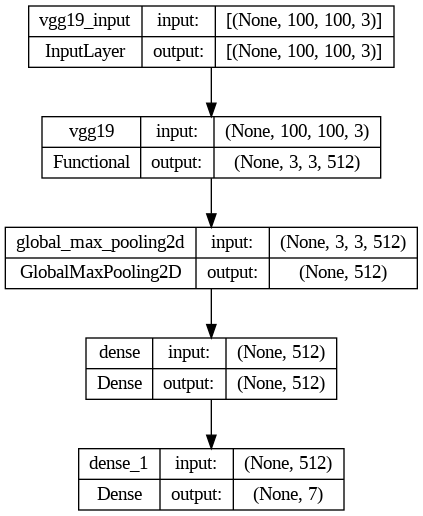

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.2,
                                                    min_lr=1e-5,
                                                    patience=3,
                                                    mode='min'
                                                    )

In [ ]:
history = model.fit(
    x_img_train,
    y_img_train,
    validation_data=(x_img_val, y_img_val),
    callbacks=[lr_scheduler],
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(x_img_train) // BATCH_SIZE,
    validation_steps=len(x_img_val) // BATCH_SIZE,
)


In [15]:
print(model.evaluate(x_img_test, y_img_test, batch_size=BATCH_SIZE, steps=len(x_img_test) // BATCH_SIZE))

122/122 [==============================] - 7s 53ms/step - loss: 1.5055 - accuracy: 0.4857
[1.50548255443573, 0.4856557250022888]


In [16]:
print(model.evaluate(x_img_val, y_img_val, batch_size=BATCH_SIZE, steps=len(x_img_val) // BATCH_SIZE))

104/104 [==============================] - 6s 55ms/step - loss: 1.3156 - accuracy: 0.5258
[1.3156453371047974, 0.5258413553237915]


In [17]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [18]:
plot_and_save('loss', history, 'Loss', 'image_loss_plot.png')
plot_and_save('accuracy', history, 'Image Classification Accuracy', 'image_class_accuracy_plot.png')

In [19]:
predictions = model.predict(x_img_test)
predictions = np.argmax(predictions, axis=1)

classes = [x for x in os.listdir(TRAIN_IMAGE_PATH)]
print(classes)

245/245 [==============================] - 8s 29ms/step
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


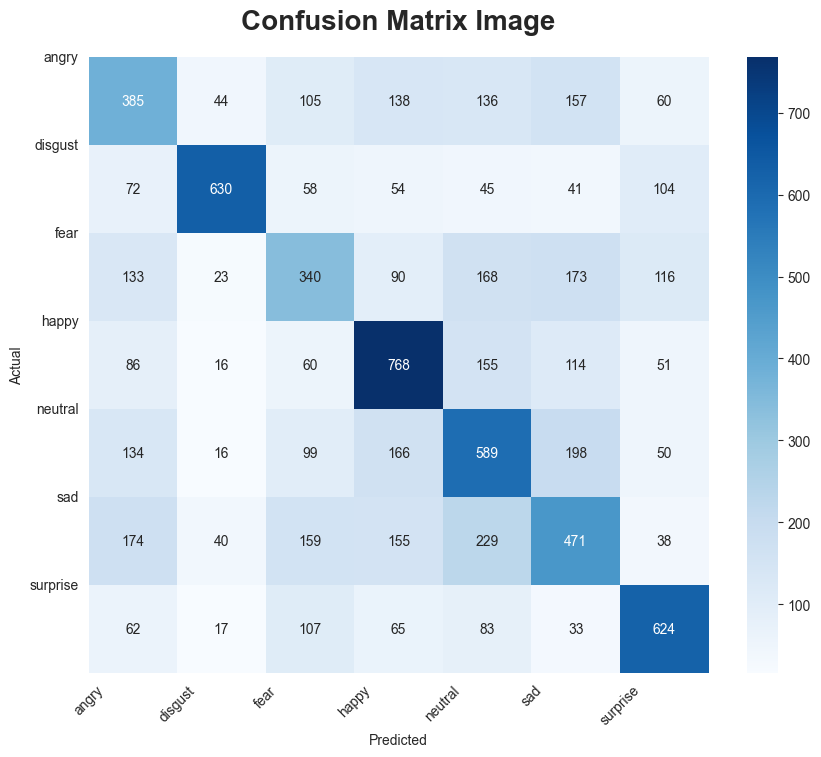

In [20]:
cm = confusion_matrix(y_img_test, predictions)

plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix Image', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)
plt.savefig('confusion_matrix_img.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
print(classification_report(predictions, y_img_test))

              precision    recall  f1-score   support

           0       0.38      0.37      0.37      1046
           1       0.63      0.80      0.70       786
           2       0.33      0.37      0.35       928
           3       0.61      0.53      0.57      1436
           4       0.47      0.42      0.44      1405
           5       0.37      0.40      0.38      1187
           6       0.63      0.60      0.61      1043

    accuracy                           0.49      7831
   macro avg       0.49      0.50      0.49      7831
weighted avg       0.49      0.49      0.49      7831



In [22]:
model.save('model_img_sc4t4.h5')

In [23]:
!zip -q -r run_kaggle.zip /kaggle/working/*.png /kaggle/working/*.h5

'zip' is not recognized as an internal or external command,
operable program or batch file.
